## imports and setup

In [1]:
from functools import partial
import numpy as np
from scipy.stats import arcsine
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from cycler import cycler
from time import perf_counter
from tqdm import tqdm
import math
import statistics

In [2]:
rng = np.random.default_rng()

In [3]:
default_cycler = plt.rcParams["axes.prop_cycle"] + cycler(linestyle=["--", "-.", ":"] + ["-"] * 7)
plt.rc("axes", prop_cycle=default_cycler)

## helper functions

In [4]:
def overlaps(r1, r2):
    r1p1, r1p2 = r1
    r2p1, r2p2 = r2
    
    r1x1, r1y1, r1x2, r1y2 = *r1p1, *r1p2
    r2x1, r2y1, r2x2, r2y2 = *r2p1, *r2p2
    
    return not (
        (
            min(r1x1, r1x2) > max(r2x1, r2x2)
            or
            max(r1x1, r1x2) < min(r2x1, r2x2)
        )
        or
        (
            min(r1y1, r1y2) > max(r2y1, r2y2)
            or
            max(r1y1, r1y2) < min(r2y1, r2y2)
        )
    )

## input distributions

In [5]:
arcsine_ = partial(arcsine.rvs, random_state=rng)
normal_ = rng.normal
uniform_ = partial(rng.uniform)

def fixed_(loc, scale, size):
    assert len(loc) == size
    return [x + scale for x in loc]

In [6]:
dist_names = {
    arcsine_: "arcsine",
    normal_: "normal",
    uniform_: "uniform",
    fixed_: "fixed"
}

In [7]:
# p1_dists = (arcsine_, normal_, uniform_)
p1_dists = (normal_, uniform_)
# p2_dists = (arcsine_, normal_, fixed_)
p2_dists = (arcsine_, fixed_)

In [8]:
def gen_rectangle(p1_dist, p2_dist, scale):
    p1 = p1_dist(size=2)
    p2 = p2_dist(loc=p1, scale=scale, size=2)
    
    return p1, p2

## solvers

In [9]:
def online_greedy(rects):
    selected = [False] * len(rects)
    for i, r1 in enumerate(rects):
        reject_r1 = False
        for j, is_in in enumerate(selected):
            if is_in and overlaps(r1, rects[j]):
                reject_r1 = True
                break
        if not reject_r1:
            selected[i] = True
    return selected

In [10]:
def offline_greedy(rects):
    indices, rects = zip(*sorted(
        enumerate(rects), 
        key=lambda idx_and_rect: max(idx_and_rect[1][0][0], idx_and_rect[1][1][0])
    ))
    selected = online_greedy(rects)
    
    res = [is_in for idx, is_in in sorted(
        zip(indices, selected), 
        key=lambda idx_and_is_in: idx_and_is_in[0]
    )]
    return res

In [11]:
alg_legend_names = {
    online_greedy: "online greedy",
    offline_greedy: "offline greedy"
}

In [12]:
algs = (online_greedy, offline_greedy)

## visualization

In [13]:
scale = 0.7
n = 60
p1_dist = normal_
p2_dist = normal_

In [14]:
rects = [gen_rectangle(p1_dist, p2_dist, scale) for _ in range(n)]

In [15]:
res_lst = []
for alg in algs:
    start_time = perf_counter()
    res = alg(rects)
    end_time = perf_counter()
    print(f"[{alg.__name__}] solution size: {res.count(True)}, time: {end_time - start_time} sec.")
    res_lst.append((alg.__name__, res))

[online_greedy] solution size: 27, time: 0.01878240000223741 sec.
[offline_greedy] solution size: 31, time: 0.01198919999296777 sec.


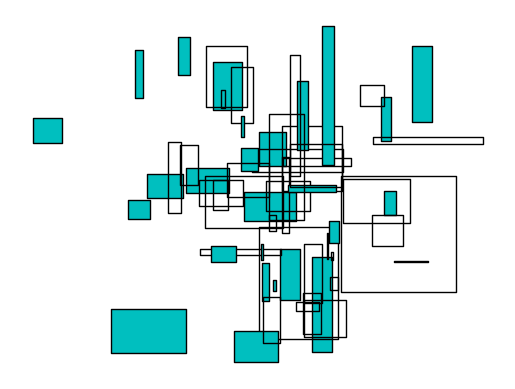

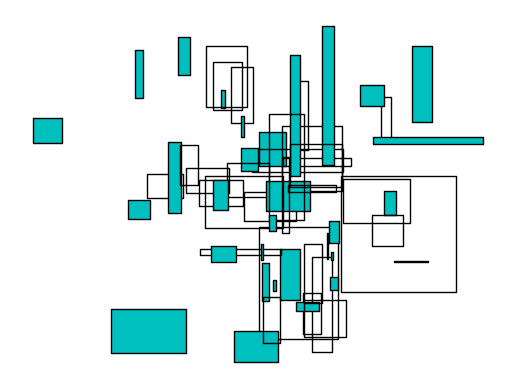

In [16]:
for alg_name, res in res_lst:
    fig, ax = plt.subplots()
    patches = []
    for p1, p2 in rects:
        patches.append(Rectangle(p1, p2[0] - p1[0], p2[1] - p1[1]))
    ax.add_collection(PatchCollection(patches, edgecolors="black", facecolors=["c" if x else "none" for x in res]))
    ax.set_axis_off()
    ax.autoscale()
    plt.savefig(f"visualization_{dist_names[p1_dist]}_{dist_names[p2_dist]}_{alg_name}.pdf", bbox_inches="tight", pad_inches=-0.1)

## experiments

In [17]:
def run_experiment(param_name, param_domain):
    # set value for inactive parameter
    n = 200
    scale = 0.3
    
    # constants
    input_fluc_amt = 5
    time_fluc_amt = 3

    # set up progress bar
    tqdm._instances.clear()
    total_iters = len(p1_dists) * len(p2_dists) * len(param_domain) * input_fluc_amt * len(algs) * time_fluc_amt
    pbar = tqdm(total=total_iters)

    props = []
    times = []
    for p1_dist in p1_dists:
        p2_props = []
        p2_times = []
        for p2_dist in p2_dists:
            param_props = []
            param_times = []
            for param in param_domain:
                # identify active parameter
                if param_name == "n":
                    n = param
                if param_name == "scale":
                    scale = param
                
                fluc_rects = [[gen_rectangle(p1_dist, p2_dist, scale) for _ in range(n)] for _ in range(input_fluc_amt)]
                alg_props = []
                alg_times = []
                for alg in algs:
                    fluc_props = []
                    fluc_times = []
                    for i in range(input_fluc_amt):  # to even out fluctuations in input
                        time = math.inf
                        for _ in range(time_fluc_amt):  # to even out fluctuations in time
                            start_time = perf_counter()
                            res = alg(fluc_rects[i])
                            end_time = perf_counter()
                            time = min(time, end_time - start_time)
                            pbar.update()
                        prop = res.count(True) / n
                        fluc_props.append(prop)
                        fluc_times.append(time)
                    alg_props.append(statistics.fmean(fluc_props))
                    alg_times.append(statistics.fmean(fluc_times))
                param_props.append(alg_props)
                param_times.append(alg_times)
            p2_props.append(param_props)
            p2_times.append(param_times)
        props.append(p2_props)
        times.append(p2_times)

    pbar.close()
    
    return props, times

In [18]:
def plot_results(props, times, param_name, param_desc, param_domain):
    for i in range(len(p1_dists)):
        for j in range(len(p2_dists)):
            fig, axs = plt.subplots(2, figsize=(3,5), sharex=True, layout="tight")
            axs[0].plot(param_domain, props[i][j])
            axs[1].plot(param_domain, times[i][j], label=[alg_legend_names[alg] for alg in algs])
            axs[1].set_xlabel(param_desc)
            axs[1].legend()

            axs[0].set_ylim(0,1)
            axs[0].set_ylabel("proportion of input selected")

            axs[1].set_ylabel("time (s)")

            plt.savefig(f"varying_{param_name}_{dist_names[p1_dists[i]]}_{dist_names[p2_dists[j]]}.pdf", bbox_inches="tight")

100%|█████████████████████████████████████████████████████████████| 960/960 [02:27<00:00,  6.50it/s]


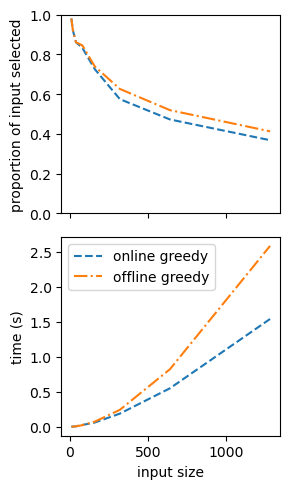

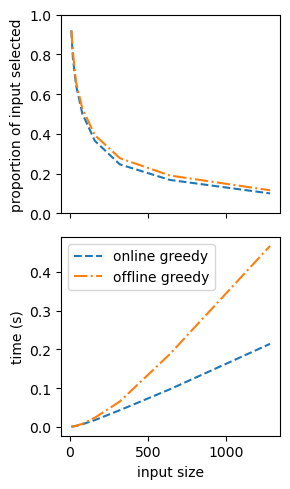

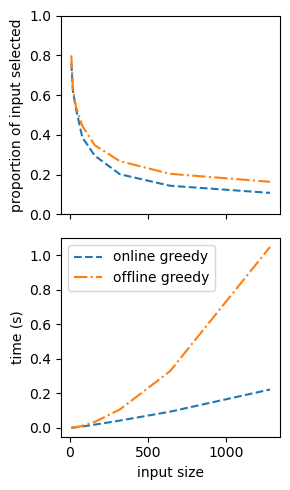

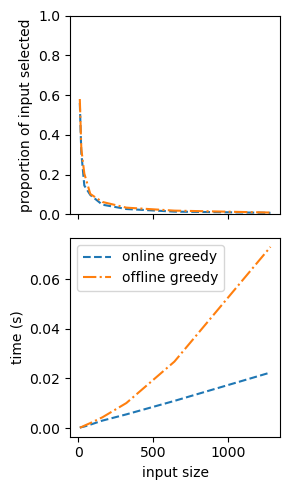

In [19]:
n_name = "n"
n_desc = "input size"
n_domain = [10, 20, 40, 80, 160, 320, 640, 1280]

props, times = run_experiment(n_name, n_domain)
plot_results(props, times, n_name, n_desc, n_domain)

100%|█████████████████████████████████████████████████████████████| 960/960 [01:17<00:00, 12.35it/s]


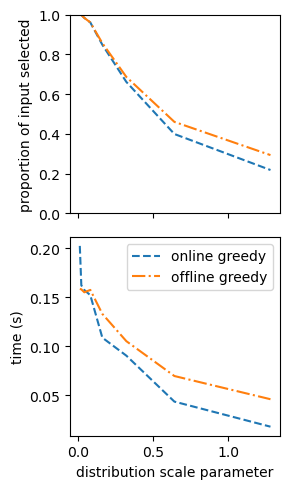

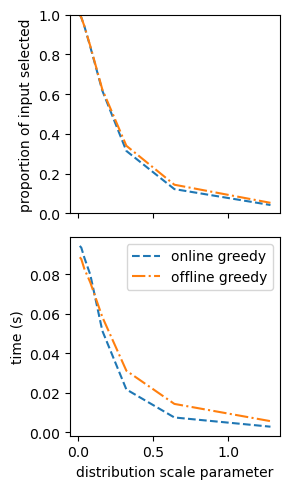

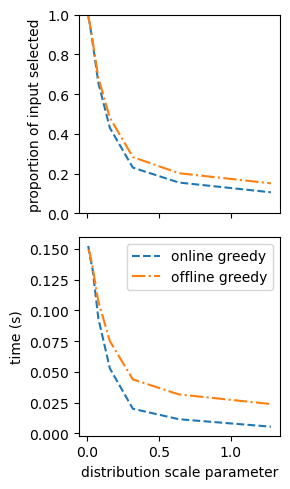

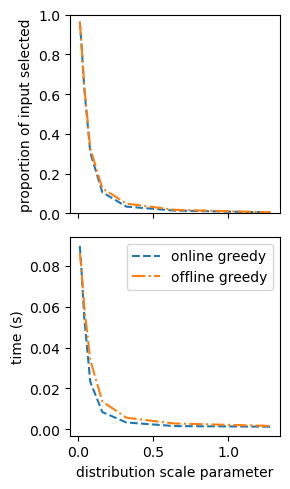

In [21]:
scale_name = "scale"
scale_desc = "distribution scale parameter"
scale_domain = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28]

props, times = run_experiment(scale_name, scale_domain)
plot_results(props, times, scale_name, scale_desc, scale_domain)